In [ ]:
!pip install trl -q # Ensure trl is installed
try:
    import trl
    print("trl is successfully installed and imported.")
except ModuleNotFoundError:
    print("trl is not installed or could not be imported.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 32.0 MB/s eta 0:00:00
trl is successfully installed and imported.


In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from tqdm import tqdm

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
)
from peft import LoraConfig, PeftModel
from datasets import Dataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from trl import SFTTrainer

In [ ]:
# ==========================================
# 1. CONFIGURATION & FILE PATHS
# ==========================================
TRAIN_FILE = "train.csv"
TEST_FILE = "test.csv"
OUTPUT_DIR = "./mistral_stance_adapters"
PREDICTION_FILE = "mistral_test_predictions.csv"
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.3"
# WARNING: Reduced batch size for 7B model stability on 16GB VRAM
BATCH_SIZE = 2

In [ ]:
# ==========================================
# 2. DATA PREPARATION (COHERENT WITH CoS & MISTRAL TEMPLATE)
# ==========================================

def prepare_data(df):
    """
    Formats the DataFrame rows for CoS fine-tuning using the Mistral Instruct template.
    """
    df['Stance'] = df['Stance'].replace('NONE', 'NEUTRAL').str.upper()

    # Mistral's prompt structure is different from Phi-3's, using [INST] tags.
    df['text'] = df.apply(
        lambda row: (
            # --- START: FULL CHAIN OF STANCE INSTRUCTION (CoS Logic) ---
            # We embed the CoS logic into the Mistral System Instruction area (inside the first [INST] block)
            f"You are a stance detection system trained on the Chain-of-Stance (CoS) methodology. "
            f"Your goal is to determine the stance of the TWEET toward a given TARGET by executing the "
            f"following reasoning pipeline internally:\n"
            f"Step 1: Understand the contextual information (identity, audience, socio-cultural background).\n"
            f"Step 2: Interpret the main ideas and core viewpoints in the TWEET (V).\n"
            f"Step 3: Analyze the language expression and emotional attitude (E).\n"
            f"Step 4: Compare the TWEET with all three possible stances (Favor, Against, Neutral) based on V and E.\n"
            f"Step 5: Conduct logical inference to confirm the consistency and rationality of the stance.\n"
            f"Step 6: Based on this entire process, determine the Final Stance polarity.\n"
            f"Respond ONLY with the Final Stance label (FAVOR, AGAINST, or NEUTRAL)."
            # --- END: FULL CHAIN OF STANCE INSTRUCTION ---

            f"[INST]TARGET: {row['Target']}\nTWEET: {row['Tweet']}[/INST]"
            f"{row['Stance']}" # Model is trained to output only the stance label here
        ), axis=1
    )
    return Dataset.from_pandas(df[['text']])

def load_and_preprocess_datasets():
    if not all([os.path.exists(TRAIN_FILE), os.path.exists(TEST_FILE)]):
        raise FileNotFoundError("Ensure train.csv and test.csv are available.")

    train_df = pd.read_csv(TRAIN_FILE)
    test_df = pd.read_csv(TEST_FILE)

    test_df['Stance'] = test_df['Stance'].replace('NONE', 'NEUTRAL').str.upper()

    if os.path.exists(OUTPUT_DIR):
        print(f"Adapters found at {OUTPUT_DIR}. Skipping fine-tuning.")
        return None, test_df
    else:
        print("Preparing training data with full CoS instruction set...")
        train_dataset = prepare_data(train_df)
        print("Training data prepared.")
        return train_dataset, test_df

In [ ]:
# ==========================================
# 3. MODEL AND LORA SETUP
# ==========================================

def setup_lora_model():
    # Mistral tokenizer config
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"

    # Load Mistral 7B (Memory configuration)
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.float16,
        device_map="auto",
        low_cpu_mem_usage=True # Crucial for Colab System RAM safety
    )
    model.config.use_cache = False

    # LoRA Configuration (Same as Chain-of-Stance paper parameters)
    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        target_modules=[
            "q_proj", "k_proj", "v_proj", "o_proj",
            "gate_proj", "up_proj", "down_proj"
        ],
        bias="none",
        task_type="CAUSAL_LM",
    )

    return model, tokenizer, lora_config

In [ ]:
# ==========================================
# 4. TRAINING AND SAVING
# ==========================================

def fine_tune(model, tokenizer, lora_config, train_dataset):
    print("\n--- Starting PURE LoRA Fine-Tuning (16-bit) ---")

    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        num_train_epochs=10,
        per_device_train_batch_size=BATCH_SIZE, # Reduced batch size for 7B stability
        gradient_accumulation_steps=1,
        learning_rate=5e-5,
        logging_steps=10,
        save_strategy="epoch",
        save_total_limit=1,
        fp16=True,
        optim="adamw_torch",
        max_grad_norm=0.3,
        warmup_ratio=0.03,
        report_to="none" # Disable W&B logging
    )

    data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

    trainer = SFTTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        peft_config=lora_config,
        data_collator=data_collator,
    )

    trainer.train()

    # Save the LoRA adapters
    trainer.model.save_pretrained(OUTPUT_DIR)
    print(f"\n✅ Fine-Tuning complete. Adapters saved to {OUTPUT_DIR}")


In [ ]:
# ==========================================
# 5. BATCH INFERENCE (TESTING)
# ==========================================

def run_batch_inference(model, tokenizer, test_df):
    print("\n--- Starting Batch Inference on Test Data ---")

    # We rebuild the CoS prompt for inference, leaving the assistant tag open
    test_prompts = test_df.apply(
        lambda row: (
            # --- START: FULL CHAIN OF STANCE INSTRUCTION (CoS Logic) ---
            f"You are a stance detection system trained on the Chain-of-Stance (CoS) methodology. "
            f"Your goal is to determine the stance of the TWEET toward a given TARGET by executing the "
            f"following reasoning pipeline internally:\n"
            f"Step 1: Understand the contextual information (identity, audience, socio-cultural background).\n"
            f"Step 2: Interpret the main ideas and core viewpoints in the TWEET (V).\n"
            f"Step 3: Analyze the language expression and emotional attitude (E).\n"
            f"Step 4: Compare the TWEET with all three possible stances (Favor, Against, Neutral) based on V and E.\n"
            f"Step 5: Conduct logical inference to confirm the consistency and rationality of the stance.\n"
            f"Step 6: Based on this entire process, determine the Final Stance polarity.\n"
            f"Respond ONLY with the Final Stance label (FAVOR, AGAINST, or NEUTRAL)."
            # --- END: FULL CHAIN OF STANCE INSTRUCTION ---

            f"[INST]TARGET: {row['Target']}\nTWEET: {row['Tweet']}[/INST]"
        ), axis=1
    ).tolist()

    predictions = []
    INFERENCE_BATCH_SIZE = 6

    for i in tqdm(range(0, len(test_prompts), INFERENCE_BATCH_SIZE), desc="Batch Testing"):
        batch_prompts = test_prompts[i : i + INFERENCE_BATCH_SIZE]

        # NOTE: Mistral's tokenizer.apply_chat_template does not prepend the BOS token
        # when using messages list, so we add the BOS token manually here in the prompt.
        # However, since we are building the prompt string manually, we rely on the
        # model generation starting token.

        inputs = tokenizer(
            batch_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(model.device)

        # Generate prediction
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=10,
                do_sample=False,
                pad_token_id=tokenizer.pad_token_id,
                # Add the starting token for the response (which is usually the BOS token)
                # This helps Mistral start generating the single word label immediately.

                # NOTE: The [INST] format implicitly signals the start of the response.
            )

        input_len = inputs['input_ids'].shape[1]
        decoded_outputs = tokenizer.batch_decode(outputs[:, input_len:], skip_special_tokens=True)

        for output in decoded_outputs:
            predictions.append(output.strip())

    return predictions

def extract_label(text):
    """
    Extracts the first word as the stance label.
    """
    try:
        # Get the first word, as the model is trained to output ONLY the label
        stance = text.split()[0].strip().upper().replace('.', '')
        if stance in ['FAVOR', 'AGAINST', 'NEUTRAL']:
            return stance
        # Mistral often prepends a token (e.g., '<s>') that is stripped by the tokenizer,
        # but if the model misfires, we rely on the strict pattern matching.
        return "ERROR_PARSE"
    except Exception:
        return "ERROR_PARSE"

In [ ]:
# ==========================================
# 6. EVALUATION AND REPORTING
# ==========================================

def evaluate_and_report(test_df, predictions_raw):
    print("\n--- Generating Final Report ---")

    # Extract the final stance
    predictions_stance = [extract_label(p) for p in predictions_raw]

    # Store raw output for inspection (helpful if the model outputs more than one word)
    test_df['Raw_Prediction'] = predictions_raw

    # Ensure all labels are standardized (lowercase)
    norm_map = {'favour': 'favor', 'none': 'neutral', 'againt': 'against'}

    y_true = test_df['Stance'].astype(str).str.lower().str.strip().replace(norm_map)
    y_pred = pd.Series(predictions_stance).astype(str).str.lower().str.strip().replace(norm_map)

    # Standard labels for the report
    labels = ['favor', 'against', 'neutral']

    # Filter out potential invalid predictions
    valid_mask = y_pred.isin(labels)

    # Apply mask to both arrays
    y_true_valid = y_true[valid_mask]
    y_pred_valid = y_pred[valid_mask]

    if len(y_true_valid) > 0:
        # Calculate metrics
        acc = accuracy_score(y_true_valid, y_pred_valid)
        f1_macro = f1_score(y_true_valid, y_pred_valid, average='macro', labels=labels)

        print("\n" + "="*40)
        print(f"Overall Accuracy: {acc:.2%}")
        print(f"Macro F1 Score:   {f1_macro:.4f}")
        print("="*40)

        # Classification Report
        print("\n--- Detailed Classification Report ---")
        print(classification_report(y_true_valid, y_pred_valid, labels=labels, zero_division=0))

        # Confusion Matrix Plot
        cm = confusion_matrix(y_true_valid, y_pred_valid, labels=labels)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=[l.capitalize() for l in labels],
                    yticklabels=[l.capitalize() for l in labels])
        plt.title('Confusion Matrix (Mistral CoS Final Label Training)')
        plt.ylabel('Actual Stance')
        plt.xlabel('Predicted Stance')
        plt.savefig('confusion_matrix_mistral.png')
        print("[Image] Confusion matrix saved as 'confusion_matrix_mistral.png'")

        # Save predictions to CSV
        test_df['Predicted_Stance'] = y_pred
        test_df.to_csv(PREDICTION_FILE, index=False)
        print(f"Predictions saved to {PREDICTION_FILE}")
    else:
        print("No valid predictions were generated by the model.")


Adapters found at ./mistral_stance_adapters. Skipping fine-tuning.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


✅ Merged fine-tuned weights for inference.

--- Starting Batch Inference on Test Data ---


Batch Testing: 100%|██████████| 201/201 [1:46:50<00:00, 31.90s/it]



--- Generating Final Report ---

Overall Accuracy: 80.02%
Macro F1 Score:   0.7753

--- Detailed Classification Report ---
              precision    recall  f1-score   support

       favor       0.76      0.90      0.82       304
     against       0.91      0.77      0.83       708
     neutral       0.60      0.76      0.67       194

    accuracy                           0.80      1206
   macro avg       0.76      0.81      0.78      1206
weighted avg       0.82      0.80      0.80      1206

[Image] Confusion matrix saved as 'confusion_matrix_mistral.png'
Predictions saved to mistral_test_predictions.csv


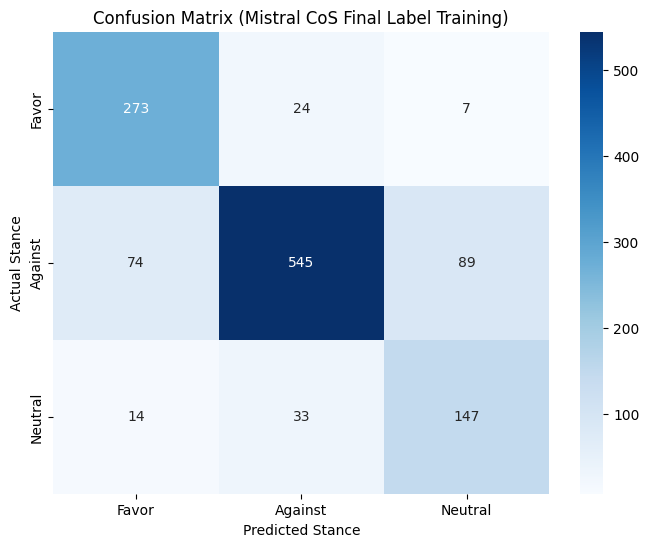

In [ ]:
# ==========================================
# 7. MAIN EXECUTION FLOW
# ==========================================

if __name__ == "__main__":
    try:
        # 1. Load/Prepare Data
        train_dataset, test_df = load_and_preprocess_datasets()

        # 2. Setup Model
        model, tokenizer, lora_config = setup_lora_model()

        # 3. Fine-Tune (Only if adapters don't exist)
        if train_dataset:
            fine_tune(model, tokenizer, lora_config, train_dataset)

        # 4. Load/Merge Adapter Weights for Inference
        try:
            best_checkpoint = OUTPUT_DIR
            # Ensure the base model is re-loaded clean before applying adapters
            base_model_inference, _, _ = setup_lora_model()

            model = PeftModel.from_pretrained(base_model_inference, best_checkpoint)
            model = model.merge_and_unload()
            print("\n✅ Merged fine-tuned weights for inference.")
        except Exception as e:
            print(f"Warning: Could not merge adapters. Running inference on base model only. Error: {e}")

        # 5. Run Batch Inference
        predictions_raw = run_batch_inference(model, tokenizer, test_df)

        # 6. Evaluate and Report
        evaluate_and_report(test_df, predictions_raw)

    except FileNotFoundError as e:
        print(f"File Error: {e}. Please ensure 'train.csv' and 'test.csv' are in the same directory.")
    except Exception as e:
        print(f"Critical Error during execution: {e}")

In [ ]:
import torch
import gc

print("--- Forcing GPU Memory Cleanup ---")

# 1. Delete the model object
# 'model' is the large object occupying VRAM. We must explicitly delete it.
if 'model' in locals():
    del model
    print("Model object deleted from memory.")

# 2. Clear PyTorch's internal cache
# This releases memory that PyTorch might be holding onto.
torch.cuda.empty_cache()

# 3. Trigger Python's garbage collector
# This cleans up references to any deleted objects.
gc.collect()

print("GPU memory should now be free.")

--- Forcing GPU Memory Cleanup ---
GPU memory should now be free.
